## Chocolate Tutorial: Data Generation

Data generation for my chocolate tutorial.

In [6]:
# If you're running in Colab, comment out this line below
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk")

import numpy as np
import pandas as pd

import scipy.optimize
import scipy.stats

import emcee
import corner

If this doesn't work, you might need to install some packages. Comment out the lines below to do that:

In [ ]:
#!pip install seaborn
#!pip install pandas
#!pip install emcee
#!pip install corner

If you're in Colab, you'll want to clone the github repo and move into it in order to load the data:

In [ ]:
#!git clone https://github.com/dhuppenkothen/cargese2018_tutorials.git
#%cd cargese2018_tutorials/tutorial1/

In either case, you can now read in the data:

In [ ]:
df = pd.read_csv("chocolate_productivity_daniela.csv")

## A single person

Let's calculate the chocolate consumption for a single person. This is drawn from a Lorentzian function,

$$
L(x) = \frac{A}{\pi} \frac{\gamma/2}{(x-x_0)^2 + (\gamma/2)^2}
$$

where $A$ is the amplitude, $x_0$ is the centre of the Lorentzian, and $\gamma$ is the width parameter. A Lorentzian is essentially a Gaussian with broader wings, which I chose here because I didn't want to overuse the Gaussian, which will appear in several other places already.

**Caution**: By default, this function is normalized so that the integral of the Lorentzian integrates to 1. In order to make the amplitude correspond to the number of lines written, you need to multiply it by $\pi \gamma/2$!

Let's write a function to make a Lorentzian

In [7]:
def lorentzian(x, amp, x0, gamma):
    prefac = amp*gamma/2.0 # pre-factor 30*np.pi*20.0/2.0
    g = 0.5*gamma # useful, because it appears twice
    pos = (x - x0)**2. # shift position
    return prefac * g / (pos + g**2.) # put it all together

Let's make an example:

In [8]:
x = np.linspace(0, 5, 1000)

x0 = 2.5
gamma = 0.5
amp = 1.0

ll = lorentzian(x, amp, x0, gamma)

Plot the result:

<IPython.core.display.Javascript object>


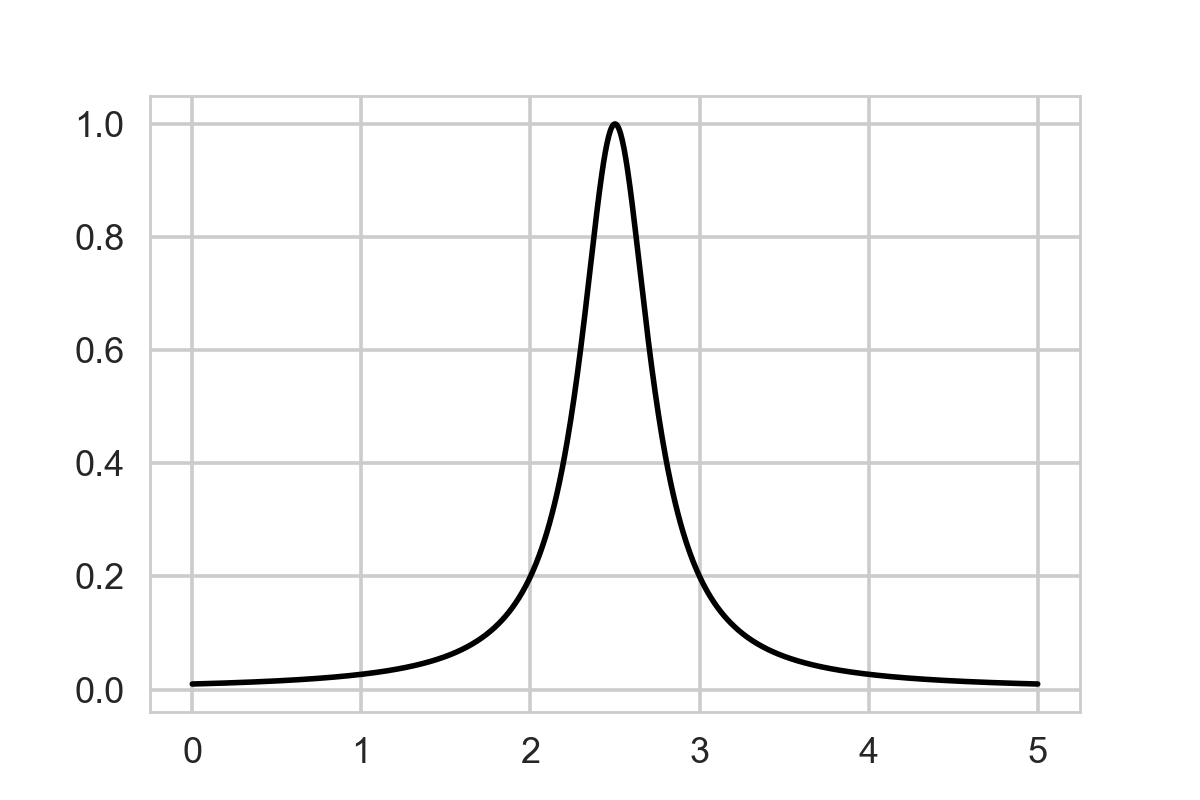

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(x, ll, lw=2, color="black")

Ok, cool, that looks like Lorentzian!

So let's think about chocolate: a whole bar is ~100g. I'm going to assert that the optimum is 25g with 5g standard deviation for different people.

For the amplitude, we're going to think about lines written, so let's say anything between 1 and 100 lines works (more than 100 lines in a day seems like a lot!). 

For the $gamma$, let's say

In [10]:
amp = 30
x0 = 25.0
gamma = 20.0

grams = np.linspace(0, 250, 1000)

lor = lorentzian(grams, amp, x0, gamma)

<IPython.core.display.Javascript object>


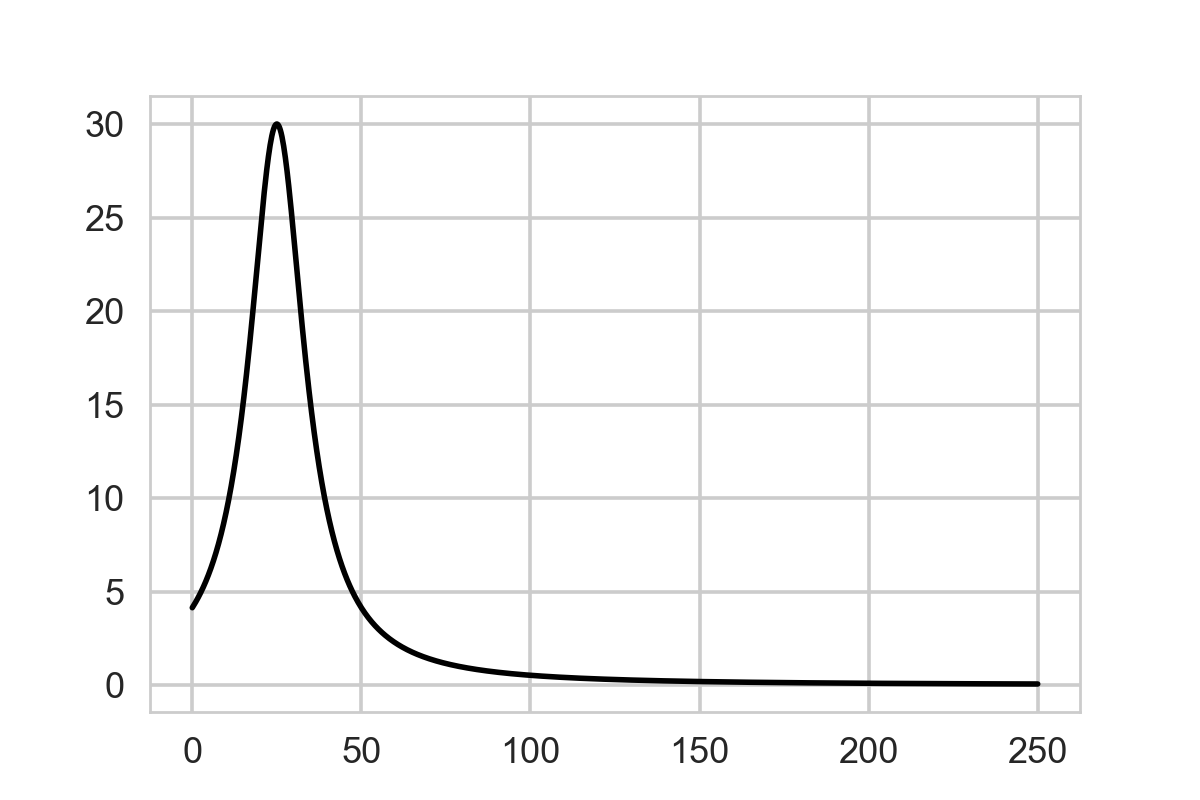

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(grams, lor, lw=2, color="black")

### The True Distributions

Both the centre of the Lorentzian (the peak productivity) $x_0$ and the width of the Lorentzian $\gamma$ are drawn from a Gaussian. 

For the peak productivity, we have a Gaussian with mean $25.0$ and variance of $5$:

In [12]:
import scipy.stats

In [82]:
peak_prod_dist = scipy.stats.norm(25.0, 1.0)

For the width, we use a Gaussian on the log, because the width can't be < 0. The mean is $\mu_\gamma = log(10.0)$ and the width is $0.25$:

In [83]:
logwidth_dist = scipy.stats.norm(np.log(10.0), 0.25)

We don't much care about the peak amplitude, but we're going to draw it from a flat distribution on the log-amplitude between 20 lines and 200 lines:

In [84]:
logamp_dist = scipy.stats.uniform(np.log(20.0), np.log(60) - np.log(20))

Let's draw some true parameters for a single person:

In [85]:
# set the random state
rng = np.random.RandomState(100)

true_x0 = peak_prod_dist.rvs(random_state=rng) # sample true peak productivity
true_logamp = logamp_dist.rvs(random_state=rng) # sample true log-amplitude
true_loggamma = logwidth_dist.rvs(random_state=rng) # sample true log-gamma

p_true = [np.exp(true_logamp), true_x0, np.exp(true_loggamma)] # set the parameter vector
print("True parameters: " + str(p_true)) # print the true parameters

# We're also going to randomly sample 30 days with different x-values:
gram_dist = scipy.stats.uniform(0, 150) # set the distribution for sampling the grams of chocolate
ndays = 30 #number of days for which the experiment ran 
x1 = gram_dist.rvs(size=ndays, random_state=rng) # the distribution of grams

lor = lorentzian(x1, *p_true) # pull measurements from the Lorentzian

# There's also some uncertainty in the measurements of lines, 
# because I occasionally squinted and I'm not perfect at counting:

sigma_prod = 3.0 # width of the uncertainties on the number of lines
sigma_dist = scipy.stats.norm(lor, sigma_prod) # set the normal distribution for the uncertainties

prod = sigma_dist.rvs(size=30, random_state=rng) # draw from normal distribution for uncertainties

True parameters: [68.41343783625463, 23.549051750633744, 16.12423430312323]


<IPython.core.display.Javascript object>


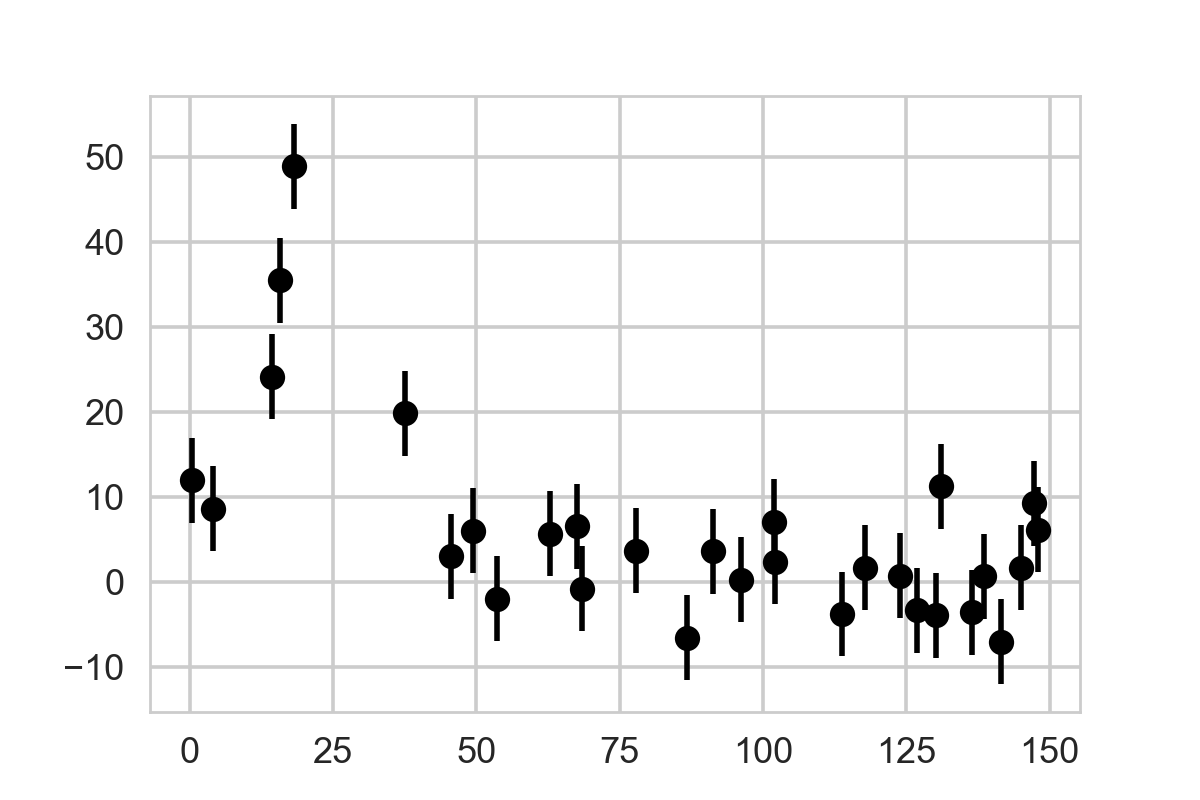

<ErrorbarContainer object of 3 artists>

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.errorbar(x1, prod, yerr=sigma_prod, lw=2, color="black", fmt="o")

Ok, cool. Let's make this into a function so I can do this for multiple people:

In [88]:
def sample_chocolate_productivity(seed, sigma_prod=3, ndays=30):
    """
    Sample data for the grams of chocolate consumed per day versus the 
    number of lines of text written per day for a person.
    
    The intrinsic distributions for the true underlying values are 
    hard-coded. This is what we're going to infer later on.
    
    Parameters
    ----------
    seed : int
        The seed for the random number generator

    sigma_prod : float
        The uncertainty on the productivity measurements, default 5
        
    ndays : int
        The number of days for which the experiment ran, default 30
        
    
    Returns
    -------
    grams, prod, prod_err : np.ndarrays
        The measured productivity and productivity errors for the number 
        of grams of choclate consumed per day
        
    true_pars : [true_amplitude, true_x0, true_gamma]
    """
    
    # distribution for the peak productivity
    peak_prod_dist = scipy.stats.norm(25.0, 1.0)
    
    # distribution for the log-width of the Lorentzian
    logwidth_dist = scipy.stats.norm(np.log(10.0), 0.25)

    # distribution for the log-amplitude, i.e. the log-productivity
    logamp_dist = scipy.stats.uniform(np.log(20.0), np.log(100) - np.log(20))
    
    # set the random state
    rng = np.random.RandomState(seed)

    true_x0 = peak_prod_dist.rvs(random_state=rng) # sample true peak productivity
    true_logamp = logamp_dist.rvs(random_state=rng) # sample true log-amplitude
    true_loggamma = logwidth_dist.rvs(random_state=rng) # sample true log-gamma

    p_true = [np.exp(true_logamp), true_x0, np.exp(true_loggamma)] # set the parameter vector
    print("True parameters: " + str(p_true)) # print the true parameters

    # We're also going to randomly sample 30 days with different x-values:
    gram_dist = scipy.stats.uniform(0, 150) # set the distribution for sampling the grams of chocolate
    grams = gram_dist.rvs(size=ndays, random_state=rng) # the distribution of grams

    lor = lorentzian(grams, *p_true) # pull measurements from the Lorentzian

    # There's also some uncertainty in the measurements of lines, 
    # because I occasionally squinted and I'm not perfect at counting:

    sigma_dist = scipy.stats.norm(lor, sigma_prod) # set the normal distribution for the uncertainties

    prod = sigma_dist.rvs(size=ndays, random_state=rng) # draw from normal distribution for uncertainties
    prod_err = np.ones_like(prod) * sigma_prod
    
    return grams, prod, prod_err, p_true

In [89]:
seed = 100

grams1, prod1, prod_err1, true_pars1 = sample_chocolate_productivity(seed)

True parameters: [39.605459645805304, 23.250234526945302, 10.894468614011808]


Let's put this into a data frame so we can use it later:

In [90]:
df = pd.DataFrame({"grams":grams1, "prod":prod1, "prod_err":prod_err1,
                   "name": "Daniela", "name_id":0,
                   "true_amp":true_pars1[0], "true_x0":true_pars1[1], "true_gamma":true_pars1[2]})

<IPython.core.display.Javascript object>


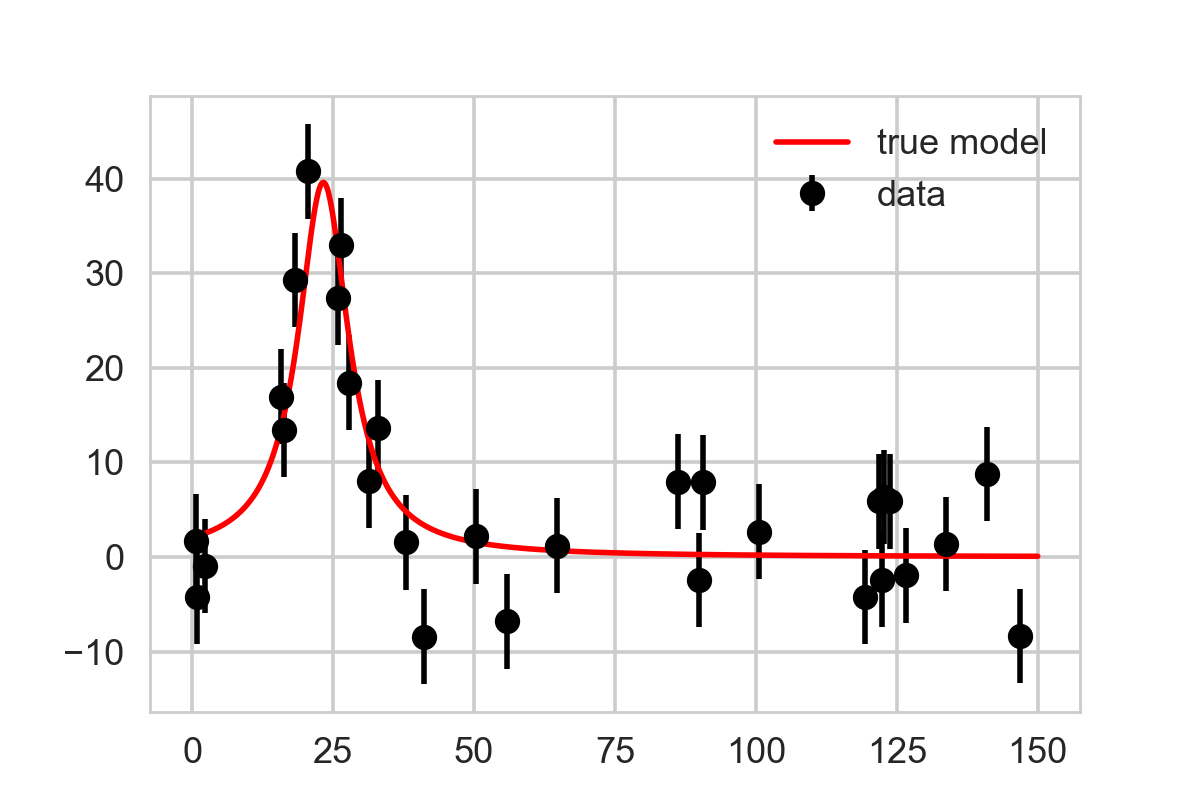

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.errorbar(grams1, prod1, yerr=prod_err1, lw=2, color="black", fmt="o", label="data")

x_test = np.linspace(0, 150, 1000)
lor_model = lorentzian(x_test, *true_pars1)

ax.plot(x_test, lor_model, lw=2, color="red", label="true model")

ax.legend()

Ok, cool. There's a person! 

## Parameter Inference for a single person

Let's now do parameter inference for a single person.

We're going to need to define the likelihood and some priors.

For the likelihood, we're going to assume Gaussian uncertainties, so a Gaussian likelihood, defined as:

$$
\mathcal{L}(\theta) = \prod_{i=1}{N}\left[\frac{1}{\sqrt{2\pi\sigma_i^2}}\exp{\left(-\frac{(y_i - f(x_i, \theta))^2}{2\sigma_i^2} \right)}   \right]
$$

where $\theta = \{A, x_0, \gamma \}$ is the set of parameters, $f(x_i, \theta)$ is the model function (i.e. the Lorentzian, $\sigma_i$ is the uncertainty in the measurement $y_i$.

**Exercise 1**: Write down the probabilistic graphical model for this problem.


**Exercise 2**: Now define the likelihood for your model in a function.

**Hints**:
* You'll want to implement the *logarithm* of the likelihood, not the likelihood itself, to avoid  numerical errors
* You might also want to check whether the value of the likelihood is finite, and if not, return -np.inf (i.e. an improbably small value), in order to avoid issues with NaNs
* Write your log-likelihood such that it takes the *logarithm* of the amplitude and of $\gamma$. Can you think of a good reason for this? Discuss with your partner!

Below, I've provided a simple structure for a likelihood class. I like writing likelihoods in classes, because it means I can call `mylikelihood(parameters)` and it will know about the data automatically! But you could also write it in a function and it'll work, too!

In [92]:
class GaussLogLike(object):
    
    def __init__(self, x, y, yerr):
        self.x = x
        self.y = y
        self.yerr = yerr
        
        # hard-coded model for this problem,
        # but could be a parameter
        self.model = lorentzian
        
    def evaluate(self, pars, neg=False):
        # calculate the underlying model for the parameters
        amp = np.exp(pars[0])
        x0 = pars[1]
        gamma = np.exp(pars[2])
        
        pars_new = [amp, x0, gamma]
        
        y_mean = self.model(self.x, *pars_new)
        
        # calculate the log-likelihood
        fac1 = 0.5*np.log(2.*np.pi*self.yerr**2.)
        fac2 = (self.y - y_mean)**2./(2.*self.yerr**2.)
        loglike = np.sum(-fac1 - fac2)
        
        if not np.isfinite(loglike):
            loglike = -np.inf
            
        if neg:
            return -loglike
        else:
            return loglike
        
    def __call__(self, pars, neg=False):
        return self.evaluate(pars, neg)

Let's try it with our test data:

In [93]:
llike = GaussLogLike(grams1, prod1, prod_err1)

In [94]:
true_pars1_log = np.array([np.log(true_pars1[0]), true_pars1[1], np.log(true_pars1[2])])

In [95]:
llike(true_pars1_log)

-94.53599698455172

In [96]:
llike(true_pars1_log+1.0)

-1217.8224347334155

In [97]:
llike(true_pars1_log-1.0)

-169.8757105836924

Ok, cool, that seems to work. Let's now also define some priors. Based on your probabilistic graphical model above, you should have an idea what parameters you'll need to define priors for. 

**Exercise**: Discuss priors with your group! What kind of priors do you think could work for the parameters here? What assumption will those priors make about the process and your data?

In [129]:
class GaussPosterior(object):
    
    def __init__(self, x, y, yerr):
        self.x = x
        self.y = y
        self.yerr = yerr
        
        # hard-coded model for this problem,
        # but could be a parameter
        self.model = lorentzian
        
        # we already have the log-likelihood defined!
        self.loglikelihood = GaussLogLike(self.x, self.y, self.yerr)
        
        self._set_logprior_dist()

    def _set_logprior_dist(self):
        """
        Set the distributions for the log-priors in advance to avoid overhead.
        """

        # flat prior on log-amplitude
        min_logamp = np.log(20)
        max_logamp = np.log(200)
        self.p_logamp = scipy.stats.uniform(min_logamp, max_logamp - min_logamp)
        
        # flat prior on x0
        self.p_x0 = scipy.stats.uniform(1, 130)
        
        # flat prior on log-gamma:
        self.p_loggamma = scipy.stats.uniform(-2, 7)
    

    def logprior(self, pars):
        return self.p_logamp.logpdf(pars[0]) + self.p_x0.logpdf(pars[1]) + self.p_loggamma.logpdf(pars[2])

    def logposterior(self, pars, neg=False):
        lpost = self.loglikelihood(pars, neg=False) + self.logprior(pars)
        
        if not np.isfinite(lpost):
            lpost = -np.inf

        if neg: 
            return -lpost
        else:
            return lpost
    
    def __call__(self, pars, neg=False):
        return self.logposterior(pars, neg)

Again, let's try it:

In [29]:
lpost = GaussPosterior(grams1, prod1, prod_err1)

In [30]:
true_pars1_log

array([ 3.97322015, 16.25117263,  2.38825519])

In [31]:
lpost(true_pars1_log)

-102.18347402931056

In [32]:
lpost(true_pars1_log+1)

-1832.8892911040768

In [33]:
lpost(true_pars1_log-1)

-inf

Hooray! That works, too! Next, we could do some maximum a-posteriori fitting.

For this we use `scipy.optimize`.

**Hint**: Be aware that optimization routines are generally *minimization* routines. So instead of maximizing the posterior, we need to minimize the negative posterior. This is why we added a `neg` keyword to our class:

In [34]:
import scipy.optimize

In [35]:
res = scipy.optimize.minimize(lpost, true_pars1_log+1, method="L-BFGS-B", args=(True))

In [36]:
res.message

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [37]:
res.x

array([ 4.07800654, 17.40251308,  2.13990407])

In [38]:
true_pars1_log

array([ 3.97322015, 16.25117263,  2.38825519])

<IPython.core.display.Javascript object>


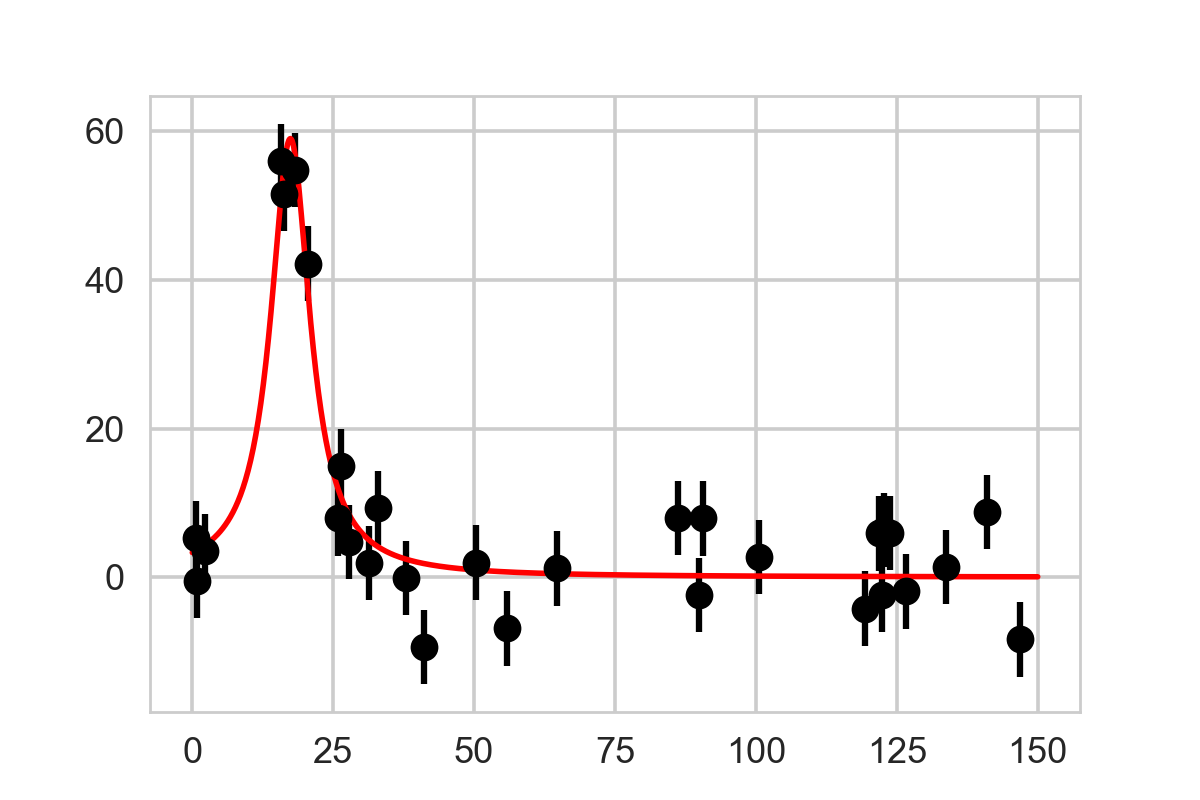

In [39]:
opt_pars = [np.exp(res.x[0]), res.x[1], np.exp(res.x[2])]
opt_lor = lorentzian(x_test, *opt_pars)

fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.errorbar(grams1, prod1, yerr=prod_err1, fmt="o", markersize=10, color="black")
ax.plot(x_test, opt_lor, lw=2, color="red")

Not bad. Let's use this to initialize an MCMC sampler:

In [40]:
res

      fun: 98.77953176158977
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.10844667e-04,  4.83169060e-05, -5.11590770e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 64
      nit: 14
   status: 0
  success: True
        x: array([ 4.07800654, 17.40251308,  2.13990407])

In [41]:
cov = res.hess_inv.todense()

In [42]:
import emcee

In [43]:
nwalkers = 36 # number of walkers
burnin = 5000 # number of samples for burn-in
niter = 1000 # number of samples in production

ndim = len(true_pars1)

sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost)


In [44]:
p0 = np.random.multivariate_normal(res.x, cov, size=nwalkers)

In [45]:
pos, prob, rstate1 = sampler.run_mcmc(p0, burnin)

Let's plot the chains:

In [46]:
np.mean(sampler.acceptance_fraction)

0.644838888888889

In [47]:
sampler.chain.shape

(36, 5000, 3)

<IPython.core.display.Javascript object>


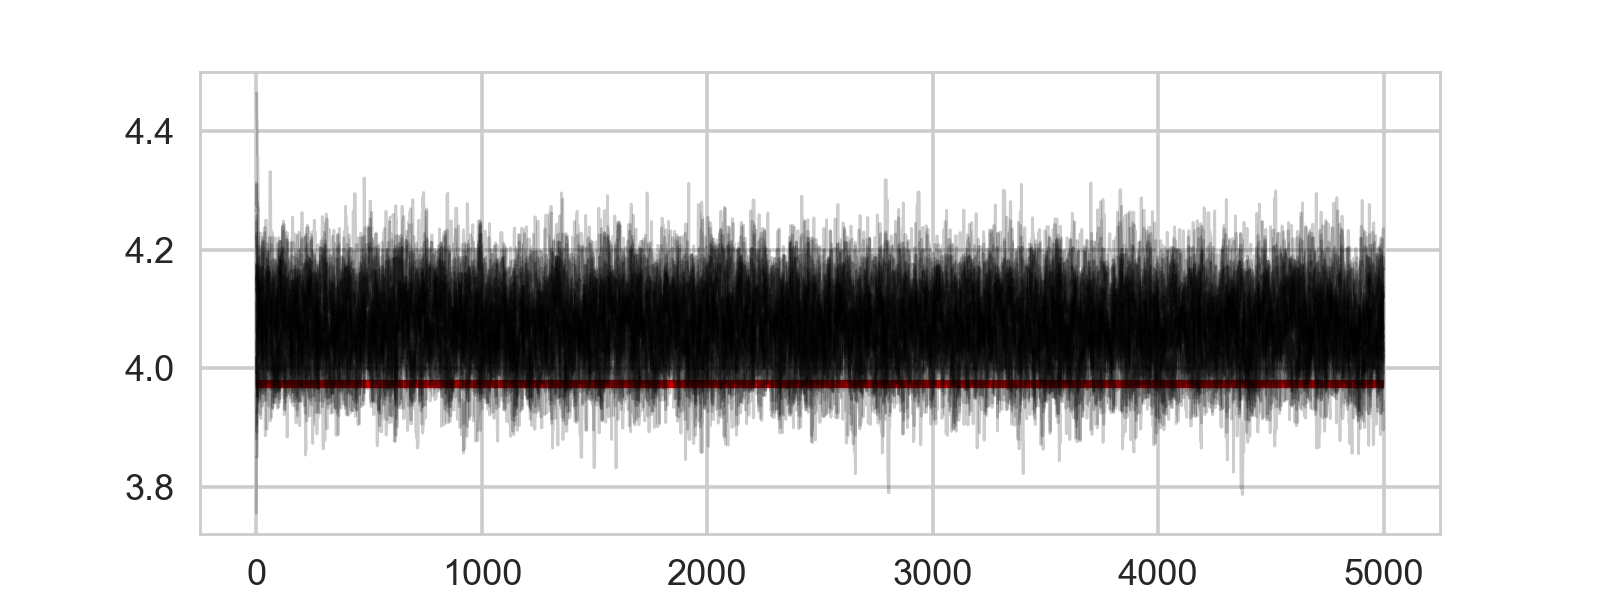

<IPython.core.display.Javascript object>


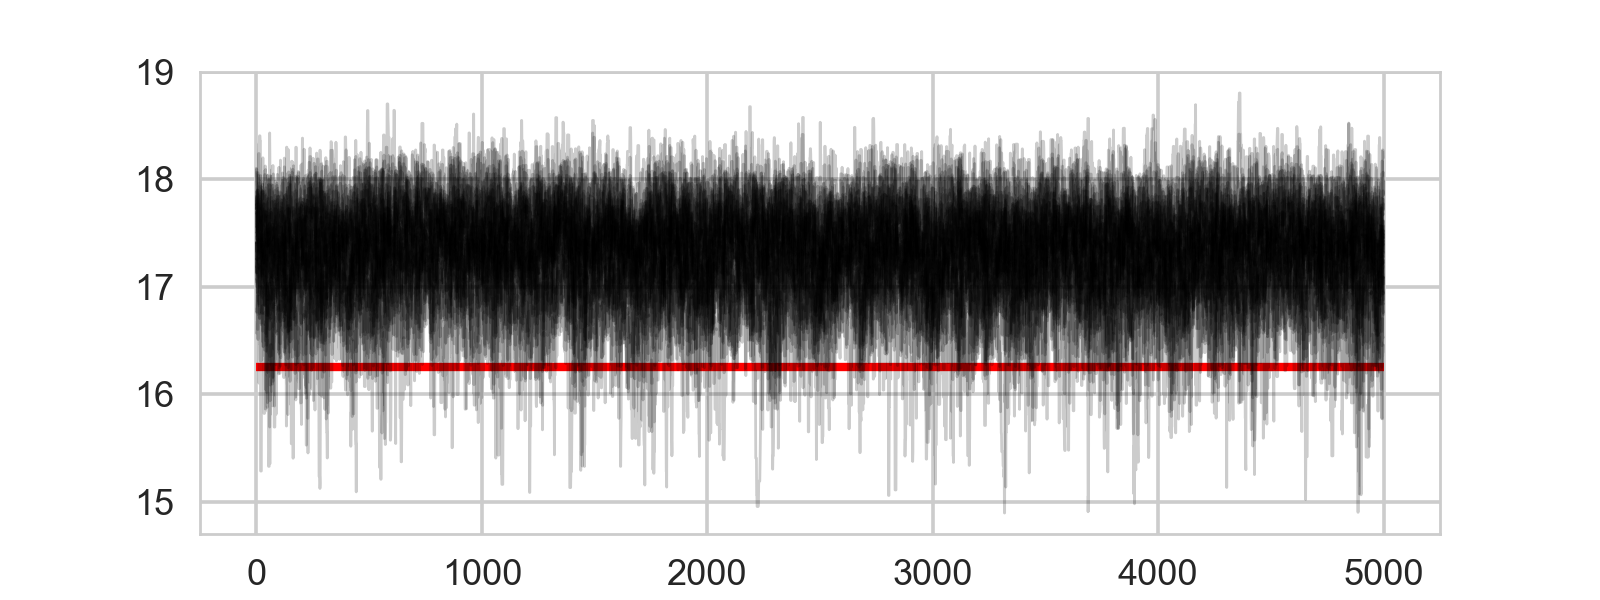

<IPython.core.display.Javascript object>


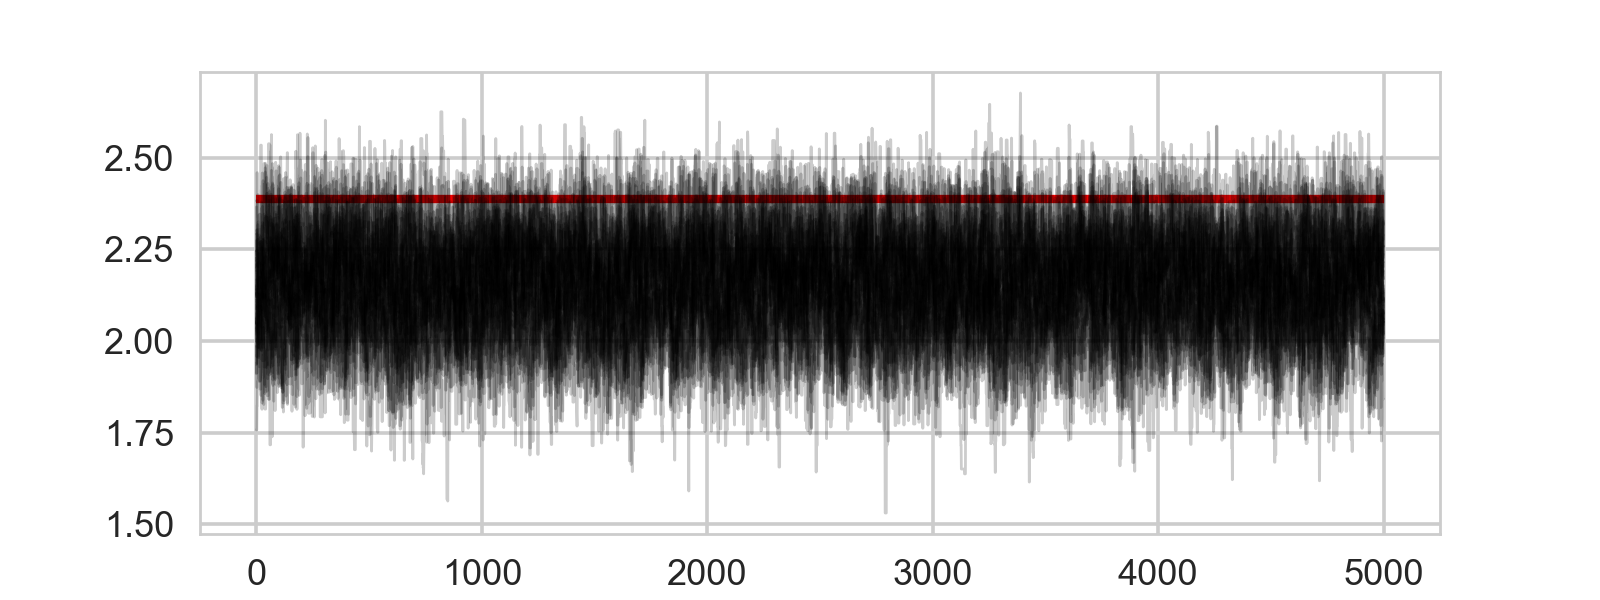

In [48]:
for i in range(ndim):
    fig, ax = plt.subplots(1, 1, figsize=(8,3))
    ax.plot(sampler.chain[:,:,i].T, lw=1, color="black", alpha=0.2)
    ax.hlines(true_pars1_log[i], 0, burnin, lw=3, color="red", zorder=10)

In [317]:
sampler.reset()

In [318]:
pos, prob, rstate1 = sampler.run_mcmc(pos, burnin, rstate0=rstate1)

<IPython.core.display.Javascript object>


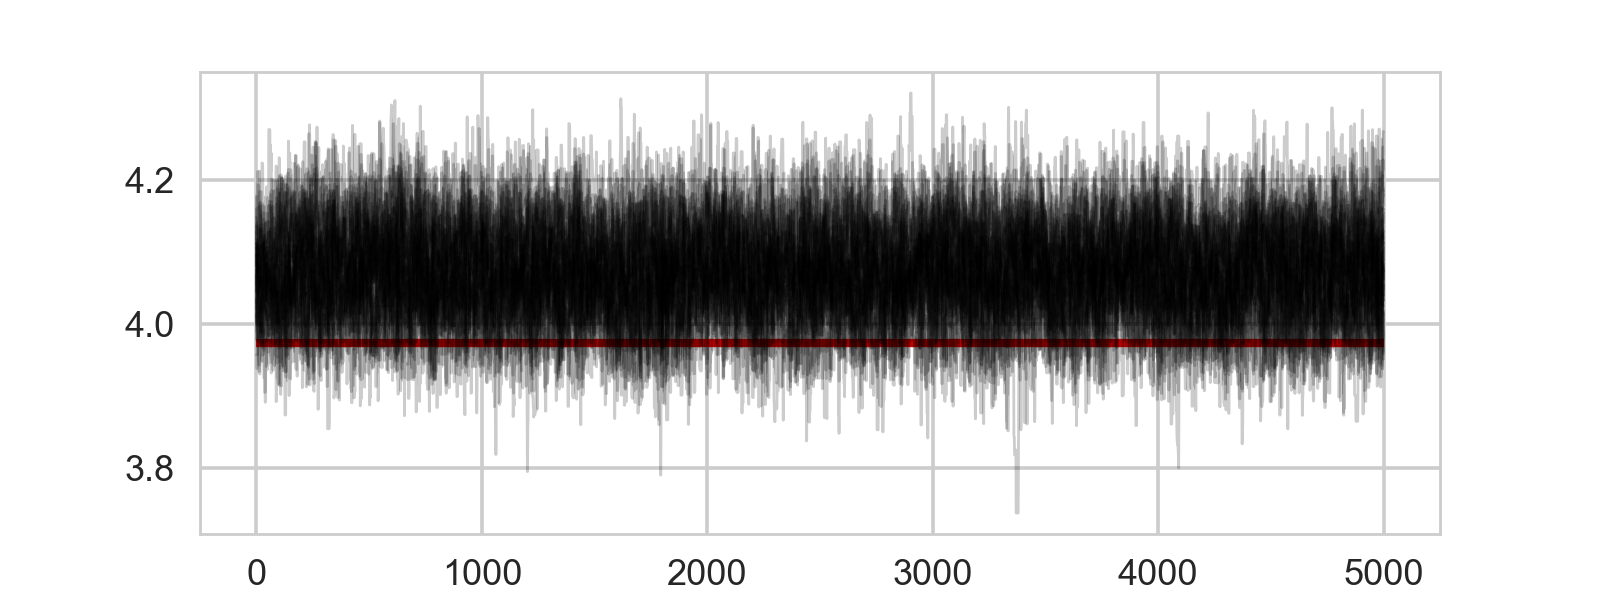

<IPython.core.display.Javascript object>


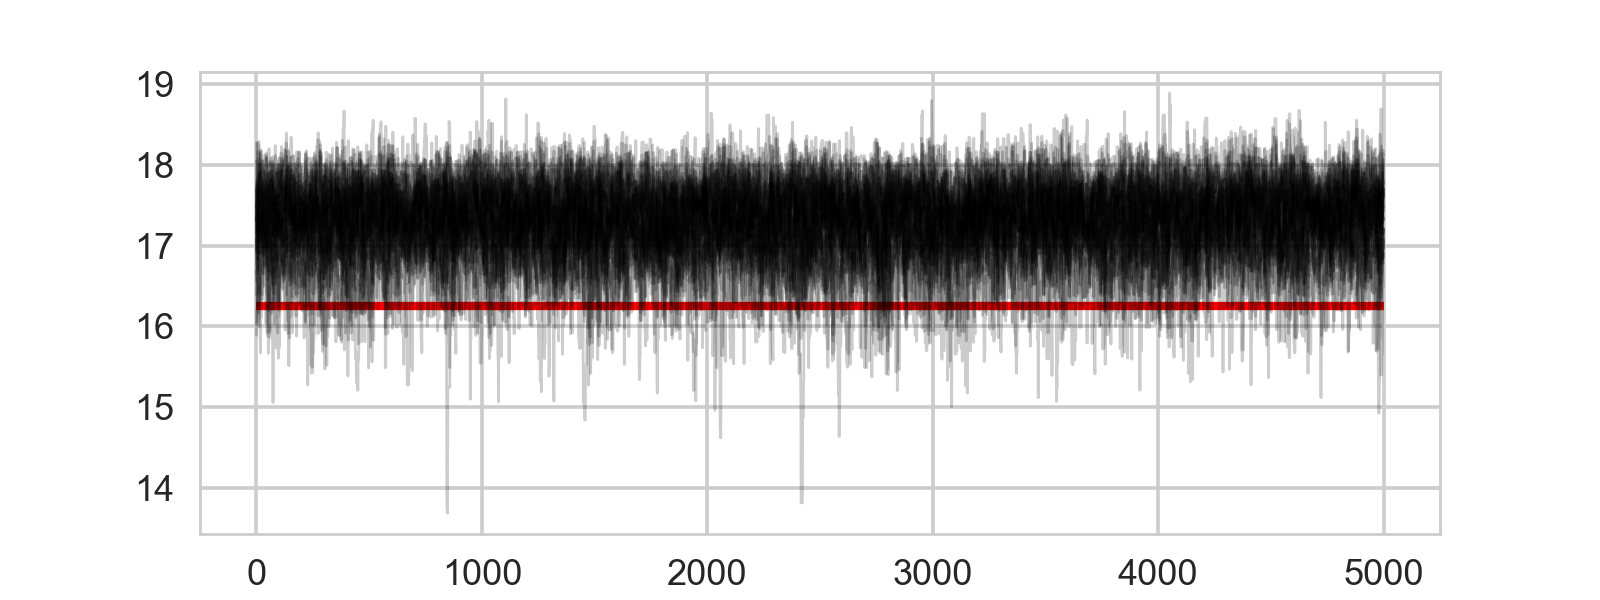

<IPython.core.display.Javascript object>


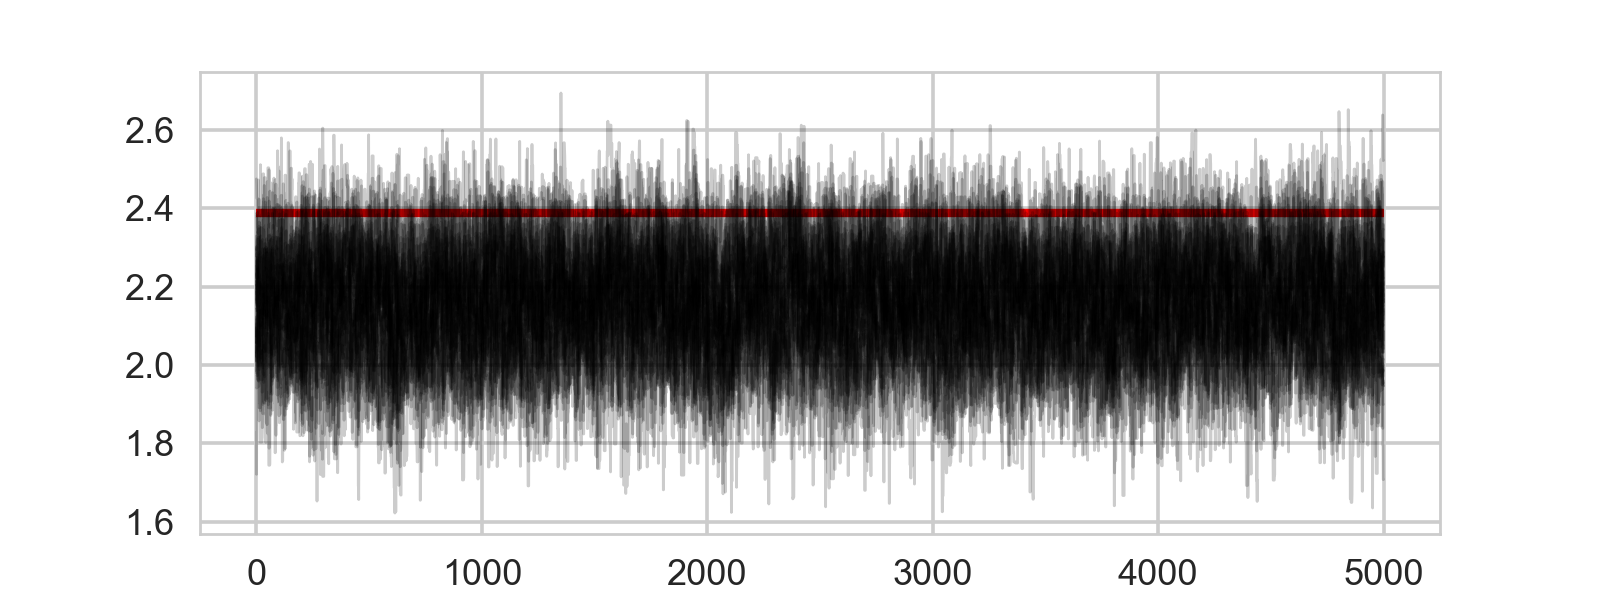

In [320]:
for i in range(ndim):
    fig, ax = plt.subplots(1, 1, figsize=(8,3))
    ax.plot(sampler.chain[:,:,i].T, lw=1, color="black", alpha=0.2)
    ax.hlines(true_pars1_log[i], 0, burnin, lw=3, color="red")

In [49]:
import corner

In [50]:
flatchain = sampler.flatchain.T

In [51]:
flatchain.shape

(3, 180000)

In [52]:
flatchain_exp = np.array([np.exp(flatchain[0]), flatchain[1], np.exp(flatchain[2])]).T

<IPython.core.display.Javascript object>


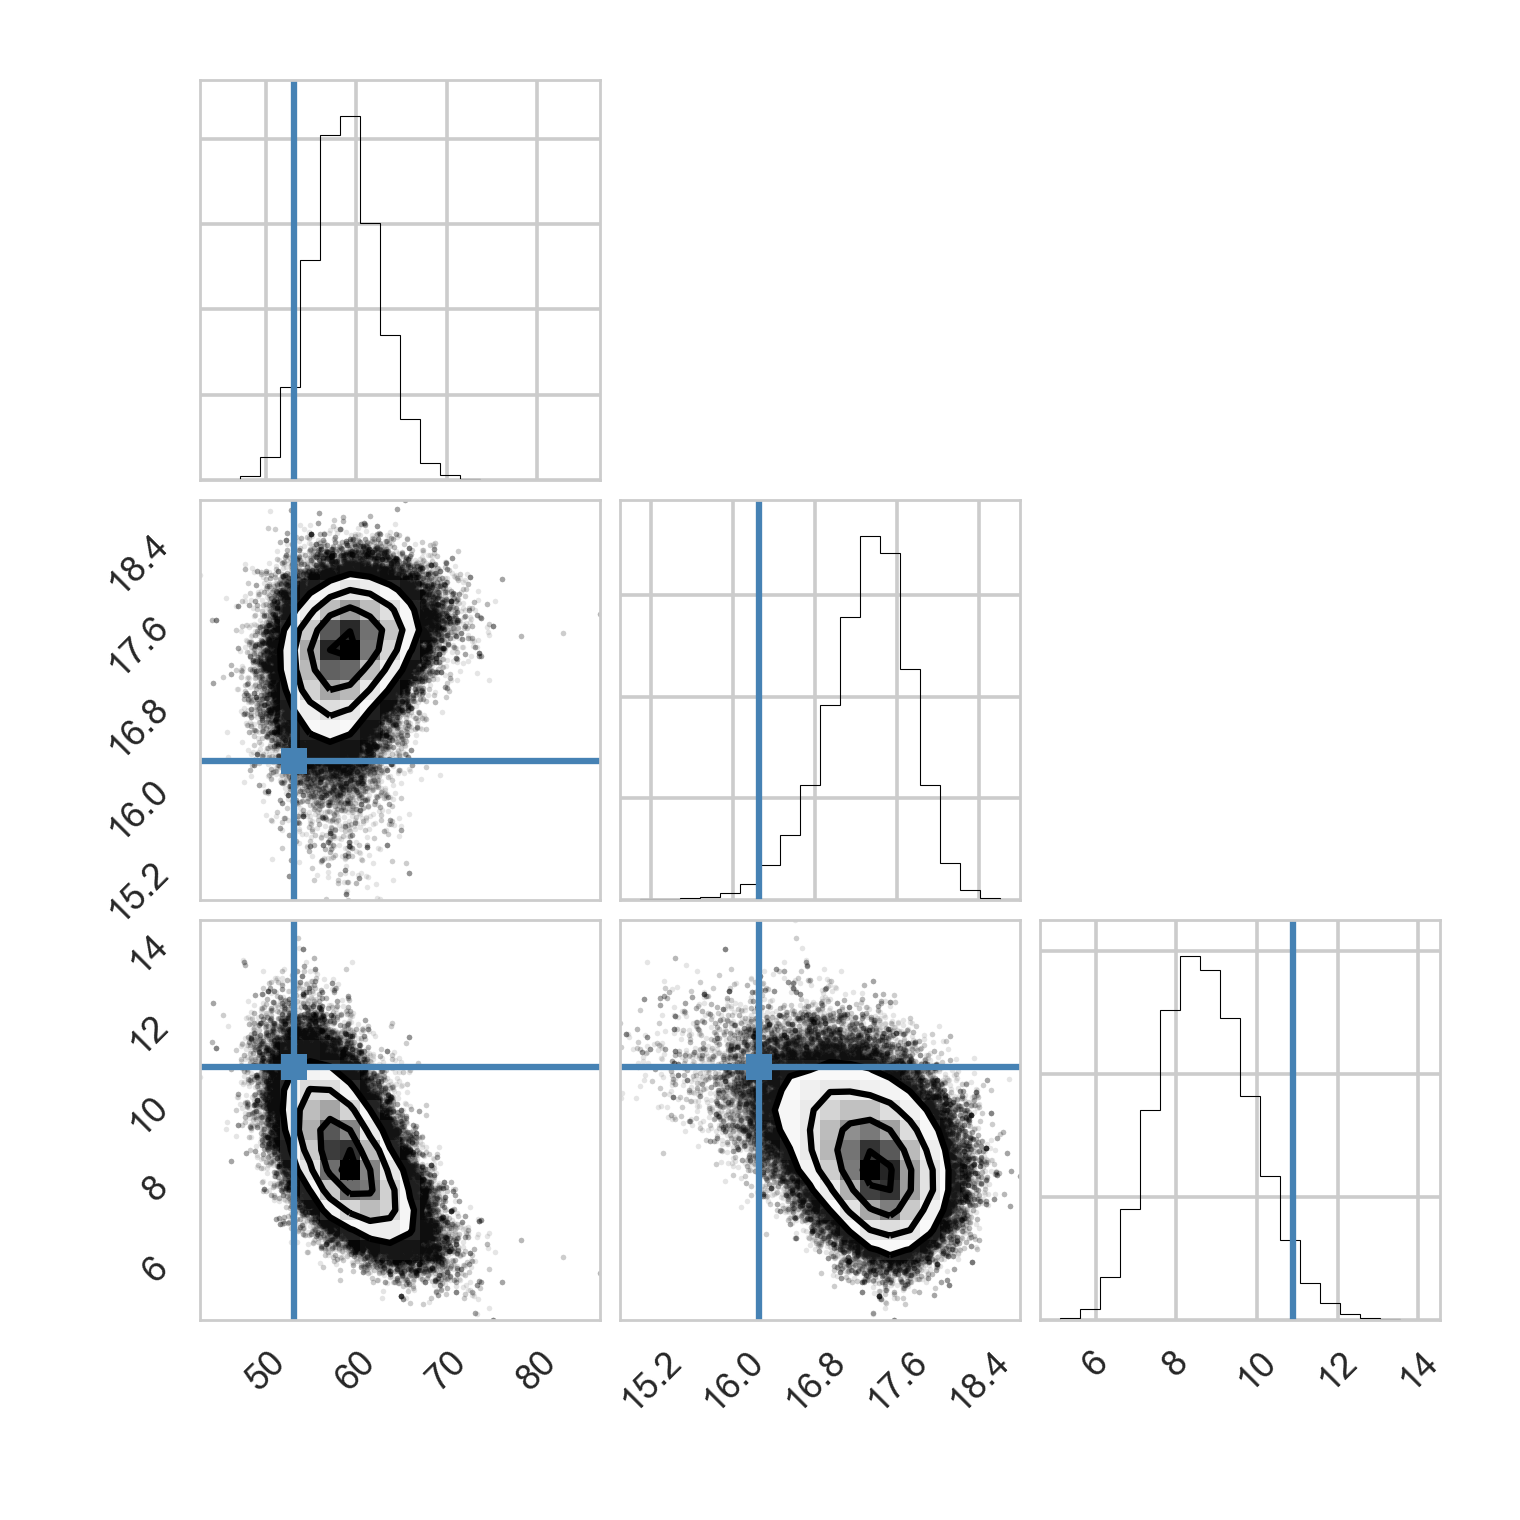

In [53]:
corner.corner(flatchain_exp, truths=true_pars1);

Okay, so this gives me a single distribution for a single person.

## Inferring Population Parameters

What we're really interested in is whether my chocolate consumption generalizes to other people, and whether we can make the whole institute more productive by giving everyone chocolate!

So I'm going to re-run my experiment with the whole institute of 28 people! 

### Making the Data:

In [99]:
npeople = 28

In [100]:
rng = np.random.RandomState(200)

seeds = scipy.stats.randint(low=0, high=2000).rvs(size=npeople, random_state=rng)

In [101]:
import names

In [102]:
names.get_first_name()

'Emma'

In [132]:
import copy

df_all = copy.deepcopy(df)

In [146]:
for i in range(npeople):
    name = names.get_full_name()
    seed = seeds[i]
    
    grams, prod, prod_err, true_pars = sample_chocolate_productivity(seed, sigma_prod=5, ndays=30)

    df_new = pd.DataFrame({"grams":grams, "prod":prod, "prod_err":prod_err, "name":name, "name_id":i+1,
                       "true_amp":true_pars[0], "true_x0":true_pars[1], "true_gamma":true_pars[2]})

    df_all = pd.concat([df_all, df_new])

True parameters: [47.6760743014633, 25.68557884968191, 6.629944203113725]
True parameters: [61.511900817368605, 24.160715522650865, 12.654758802848821]
True parameters: [22.022215758367654, 25.9594320283308, 9.62039563277]
True parameters: [78.0819228860768, 24.586514934320718, 12.960351971375017]
True parameters: [94.00588300661529, 25.129693508902488, 9.011899577702195]
True parameters: [31.181439537245755, 26.430024767444383, 8.119253672622802]
True parameters: [26.507786385277846, 25.565332495379252, 10.585370973826809]
True parameters: [28.91303103498734, 25.34015571568828, 7.915675434167006]
True parameters: [44.481460997337436, 26.46924822951379, 7.501095049871185]
True parameters: [20.61049157619294, 24.981123489404677, 8.15432480713574]
True parameters: [86.7564348055993, 24.42863038642775, 8.188172489090428]
True parameters: [37.72562462187575, 25.044711794736223, 7.599960506420216]
True parameters: [23.13009050679664, 25.46200331540141, 12.98106813809141]
True parameters: [8

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


True parameters: [38.958411640245764, 24.598949753010363, 7.0508359439789325]
True parameters: [88.74067860141002, 23.925534023479862, 11.94441447755566]
True parameters: [69.16960918261154, 24.17538625961748, 6.429717012583562]
True parameters: [35.23416595996209, 25.986237875937, 11.951837512375807]
True parameters: [24.374952070519452, 23.682641529876637, 14.055881110813539]
True parameters: [34.5547523248955, 26.404102169758158, 15.860770915272054]
True parameters: [51.184429347177314, 23.929001052966637, 8.01113435579406]
True parameters: [85.92969867111317, 25.21088159524019, 7.286906734843473]
True parameters: [31.278765464481967, 25.458129404379665, 13.018905491811752]
True parameters: [76.6435993150432, 24.78869137726624, 19.369863971555958]
True parameters: [32.321699928532894, 25.176850721078864, 18.12013270451163]
True parameters: [97.93372168249921, 26.278818712305416, 9.939000956524751]


Let's save these to file:

In [147]:
df_all.to_csv("chocolate_productivity.csv")

In [148]:
df_daniela = df_all[df_all.name == "Daniela"]

In [149]:
df_daniela.to_csv("chocolate_productivity_daniela.csv")

In [150]:
df.head()

,grams,name,name_id,prod,prod_err,true_amp,true_gamma,true_x0
0,126.716420,Daniela,0.0,-1.930726,5.0,39.60546,10.894469,23.250235
1,0.707828,Daniela,0.0,1.665418,5.0,39.60546,10.894469,23.250235
2,18.235368,Daniela,0.0,29.272610,5.0,39.60546,10.894469,23.250235
3,100.612363,Daniela,0.0,2.680514,5.0,39.60546,10.894469,23.250235
4,123.877913,Daniela,0.0,5.895080,5.0,39.60546,10.894469,23.250235


In [151]:
df.shape

(900, 8)

Ok, cool. Done!

### Parameter Inference for the hierarchical model

In a hierarchical model, we want to learn something about the *population*, rather than any individual. In the model for a single person, we assumed that we had some prior distribution, e.g. for the peak productivity, and then inferred what the peak productivity for that one person (me) was. 

In the hierarchical model, we can't assume that everyone has the same peak productivity (some people might like chocolate more than others), but we can assume that the peak productivity parameters for each person come from some distribution (which itself may be related to some underlying physical process we're interested in, let's say the conversion rate of chocolate to brainpower). We're going to infer the *parameters* of that distribution along with the parameters of all the individual people in my sample. 

In our model for a single person, we had

$$
p(\theta | y) \propto p(y | \theta) p(\theta)
$$

where $\theta = \{\log(A), x_0, \log(\gamma)\}$. Instead of the rather uninformative flat priors on all of the parameters we've assumed above, we're going to assume that the peak productivity $x_0$ and the width $\log(\gamma)$ follow normal distributions with parameters $\alpha = \{\mu_x0, \sigma_x0, \mu_\gamma, \sigma_\gamma\}$. These parameters $\alpha$ are commonly called *hyperparameters*. Our model is getting slightly more complex, because now we have

$$
p(\theta, \alpha | y) \propto p(y | \theta) p(\theta | \alpha) p(\alpha) \; .
$$

Notice how the likelihood $p(y | \theta)$ still only depends on $\theta$ (not on $\alpha$, but $\alpha$ now controls the *prior* distribution for the parameters in $\theta$. In order to infer the parameters $\alpha$, we need to give them priors as well!

**Exercise**: Draw a probabilistic graphical model for the hierarchical problem.

In [141]:
#!pip install pymc3

In [142]:
import pymc3 as pm

Let's build a model for a single person using probabilistic programming. This is going to be much less verbose than all the code we've written above.

First, let's extract a single person from our data frame:

In [143]:
c_data = df.loc[df.name == "Daniela"]

In [144]:
c_data = c_data.reset_index(drop=True)

Now you should extract the productivity, the corresponding grams of chocolate and the uncertainties on our productivity measurements. 

**Hint**: these probably need to be converted to numpy arrays, because pymc3 won't deal well with pandas `Series` objects:

In [145]:
productivity = np.array(c_data["prod"])
grams = np.array(c_data["grams"])

prod_err = np.array(c_data["prod_err"])

In [115]:
c_data.columns

Index(['grams', 'name', 'name_id', 'prod', 'prod_err', 'true_amp',
       'true_gamma', 'true_x0'],
      dtype='object')

In [131]:
# number of people
n_names = len(df["name_id"].unique())

In [124]:
with pm.Model() as chocolate_model:
    # first, let's define some priors
    # here's an example:
    #a = pm.Normal('alpha', mu=0, sd=1)
    
    # prior for the log-amplitude
    log_amp = pm.Uniform("log_amp", np.log(5), np.log(150))
    
    # prior for the log-width
    log_gamma = pm.Uniform("log_gamma", np.log(5), np.log(20))
    
    # prior for the peak productivity
    x0 = pm.Uniform("x0", 20, 100)

    # estimate the model for the parameters drawn
    #prod_est = lorentzian(grams, np.exp(log_amp), x0, np.exp(log_gamma))
    
    prefac = np.exp(log_amp)*np.exp(log_gamma)/2.0 # pre-factor 30*np.pi*20.0/2.0
    g = 0.5*np.exp(log_gamma) # useful, because it appears twice
    pos = (grams - x0)**2. # shift position
    prod_est =  prefac * g / (pos + g**2.) # put it all together
    
    
    # Data likelihood: this should be a normal distribution
    # which takes the estimated productivity as mu, the uncertainties 
    # of the productivity as standard deviation, and the 
    # `observed` keyword should be set to the actual values of the productivity
    # for one person
    y_like = pm.Normal('y_like', mu=prod_est, sd=prod_err, observed=productivity)

    # Inference button (TM)!
    indiv_trace = pm.sample(progressbar=True, steps=5000, chains=10, )


[autoreload of pymc3 failed: Traceback (most recent call last):
  File "/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/opt/local/Library/Frameworks

TypeError: super(type, obj): obj must be an instance or subtype of type

In [128]:
true_pars = {"log_amp": np.log(c_data["true_amp"].unique()), 
             "x0": c_data["true_x0"].unique(), 
             "log_gamma": np.log(c_data["true_gamma"].unique())}

In [ ]:
pm.traceplot(indiv_trace, lines=true_pars);

Let's pull out just the `x0` parameter for this model, for use later:

In [156]:
x0_indiv = indiv_trace.x0

NameError: name 'indiv_trace' is not defined

Okay, now we can set up the hierarchical model. A nice introduction in how to set up a hierarchical model with pymc3 can be found [here](https://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/).

In the example above, we set e.g. the parameters of the prior for `x0` to actual *numbers*. However, in our new hierarchical model, these will be variables, too, which themselves are drawn from statistical distributions.

In our hierarchical model, the prior distribution for `x0` is actually something that tells us something interesting about how the productivity of a *population* of people changes if you give them chocolate. 

To make our lives easier, we're going to *only* consider the parameters for the distribution of `x0`, and assume we know the parameters for the prior of `log_gamma` and `log_amp`. 

First, we're going to need to manipulate our data a bit to make it work, since we're now working with the full distribution:


In [152]:
# all productivity values for all people
productivity = np.array(df_all["prod"])

# all uncertainties for all people
prod_err = np.array(df_all["prod_err"])

# all x-values for all people
grams = np.array(df_all["grams"])

# indices for assigning the parameters correctly
prod_idx = np.array(df_all["name_id"])

Now we can set up the model similarly as above, just with additional priors for the parameters of the priors for `x0`:

In [ ]:
with pm.Model() as hierarchical_chocolate_model:
    # first, let's define some priors
    # here's an example:
    #a = pm.Normal('alpha', mu=0, sd=1)
    
    # prior for the log-amplitude
    log_amp = pm.Uniform("log_amp", np.log(5), np.log(150), shape=n_names)
    
    # prior for the log-width
    log_gamma = pm.Uniform("log_gamma", np.log(5), np.log(50), shape=n_names)
    
    # we're going to use a normal distribution for the distribution
    # of x0
    # this distribution has a mean and a standard deviation
    # for which we choose a uniform distribution for the mean 
    # and a Half-Cauchy distribution (so it's positive) for the standard
    # deviation
    
    mu_x0 = pm.Uniform("mu_x0", 10, 100)
    sd_x0 = pm.HalfCauchy("sd_x0", beta=10)
    
    # prior for the peak productivity
    x0 = pm.Normal("x0", mu_x0, sd_x0, shape=n_names)

    # estimate the model for the parameters drawn
    #prod_est = lorentzian(grams, np.exp(log_amp), x0, np.exp(log_gamma))
    
    print(log_amp[prod_idx])
    
    
    # assign the parameters for the correct person to the 
    # right position in an array corresponding to *all* 
    # gram/productivity measurements
    amp_array = np.exp(log_amp[prod_idx])
    gamma_array = np.exp(log_gamma[prod_idx])
    x0_array = x0[prod_idx]
    
    # definition of the Lorentzian
    prefac = amp_array*gamma_array/2.0 # pre-factor 
    g = 0.5*gamma_array # useful, because it appears twice
    pos = (grams - x0_array)**2. # shift position
    prod_est =  prefac * g / (pos + g**2.) # put it all together
    
    
    # Data likelihood: this should be a normal distribution
    # which takes the estimated productivity as mu, the uncertainties 
    # of the productivity as standard deviation, and the 
    # `observed` keyword should be set to the actual values of the productivity
    # for one person
    y_like = pm.Normal('y_like', mu=prod_est, sd=prod_err, observed=productivity)

    # Inference button (TM)!
    hierarchical_trace = pm.sample(progressbar=True, steps=5000, chains=10, cores=5)





Let's make an array of the true parameters:

In [155]:
# plot twist: the true values for the individual people in 
# our list are in the DataFrame you loaded!
true_log_amp = np.log(df_all["true_amp"].unique())
true_log_gamma = np.log(df_all["true_gamma"].unique())
true_x0 = df_all["true_x0"].unique()

# These are the true values of the distribution of 
# peak productivities I didn't tell you about!
true_mu_x0 = 25.0
true_sd_x0 = 1.0

true_pars = {"log_amp": true_log_amp, "log_gamma":true_log_gamma,
             "true_x0": true_x0, "mu_x0":true_mu_x0, "sd_x0": true_sd_x0}

And now we can make a trace-plot of all of the parameters with their true values:

In [ ]:
pm.traceplot(indiv_trace, lines=true_pars);

Let's also extract the `x0` for the first person from here:

In [ ]:
x0_hier = hierarchical_trace.x0[:,0]

Now we can compare the marginalized posterior of `x0` from the single-person model to the marginalized posterior of `x0` for the hierarchical model:

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

sns.distplot(x0_indiv, kde_kws={"shade": False}, ax=ax1)
ax1.set_title("Posterior from single-person model")
ax1.set_xlim(20, 25)

sns.distplot(x0_hier, kde_kws={"shade": False}, ax=ax2)
ax2.set_title("Posterior from hierarchical model")
ax2.set_xlim(20, 25)


You should now see two things: one, we did pretty well at determining the population parameters themselves. Secondly, in the plot above, you should see that the posterior for `x0` shrunk a *lot* in the hierarchical model compared to the model where we only had one person. This is called *Bayesian shrinkage*, and happens because the population now informs the posterior for our individual members.